# ATLAS GPU Training: the Python part

If you haven't started your Jupyter session yet, _do it now!_

We will be using it, and it takes about 15 minutes to launch.

<br>

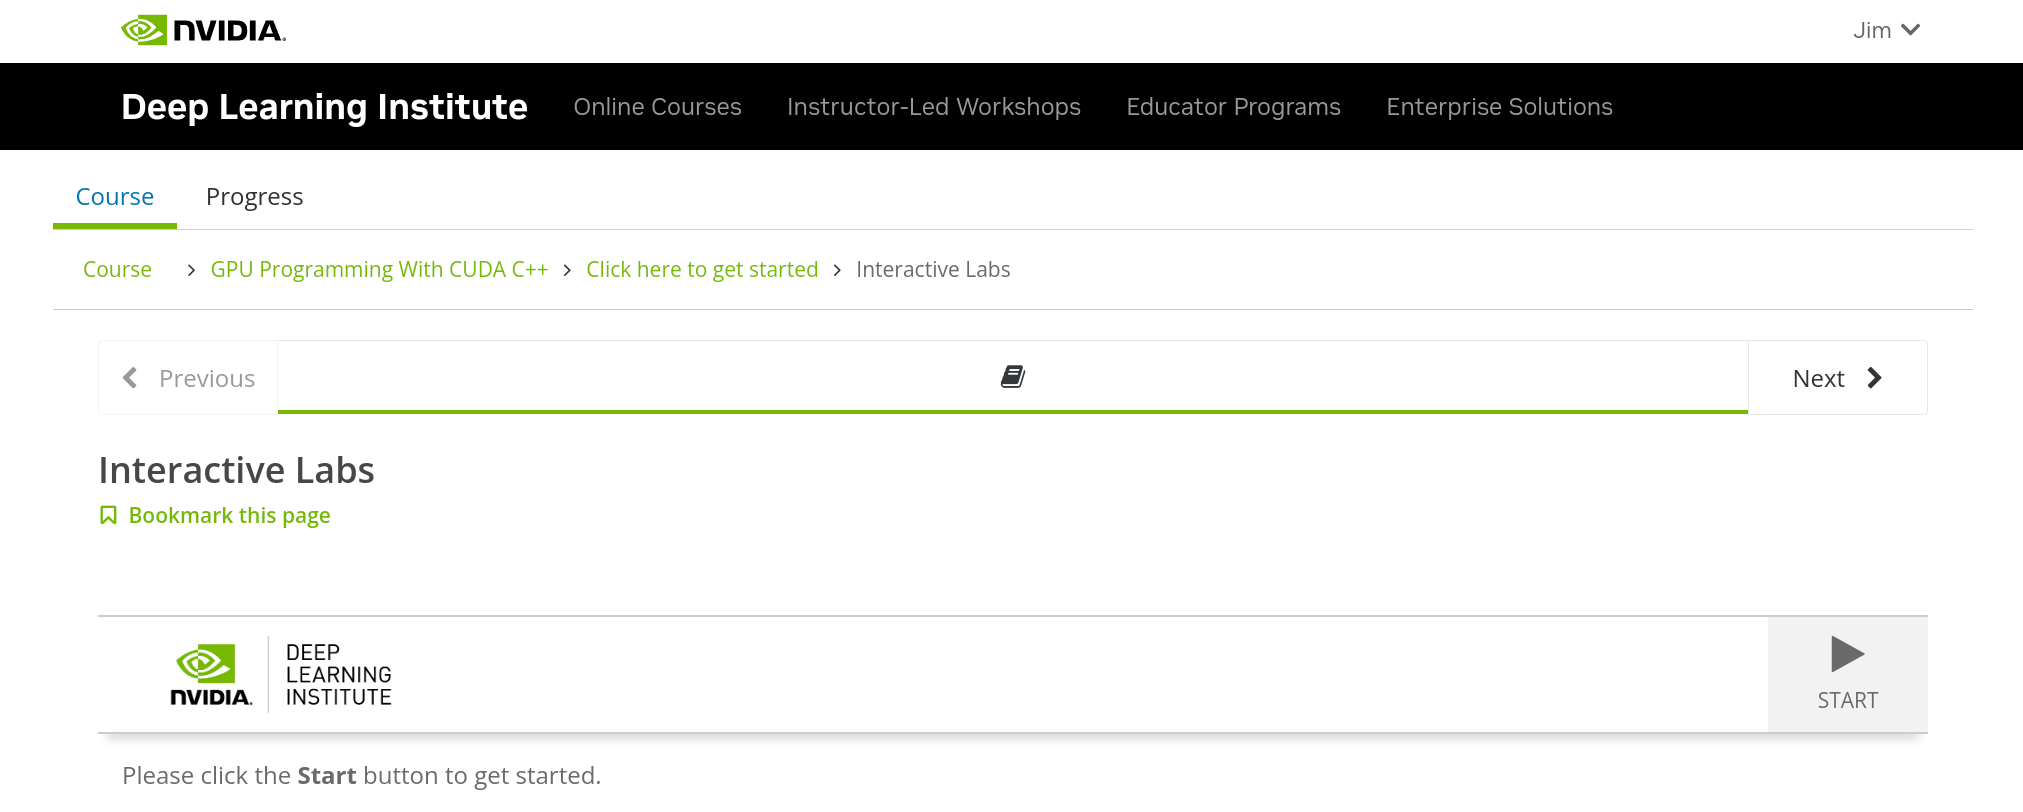

Once Jupyter has started, follow the Python installation instructions on (link in Indico)

<center><a href="https://github.com/jpivarski-talks/2023-11-02-atlas-gpu-python-tutorial"><b>https://github.com/jpivarski-talks/2023-11-02-atlas-gpu-python-tutorial</b></a></center>

<br>

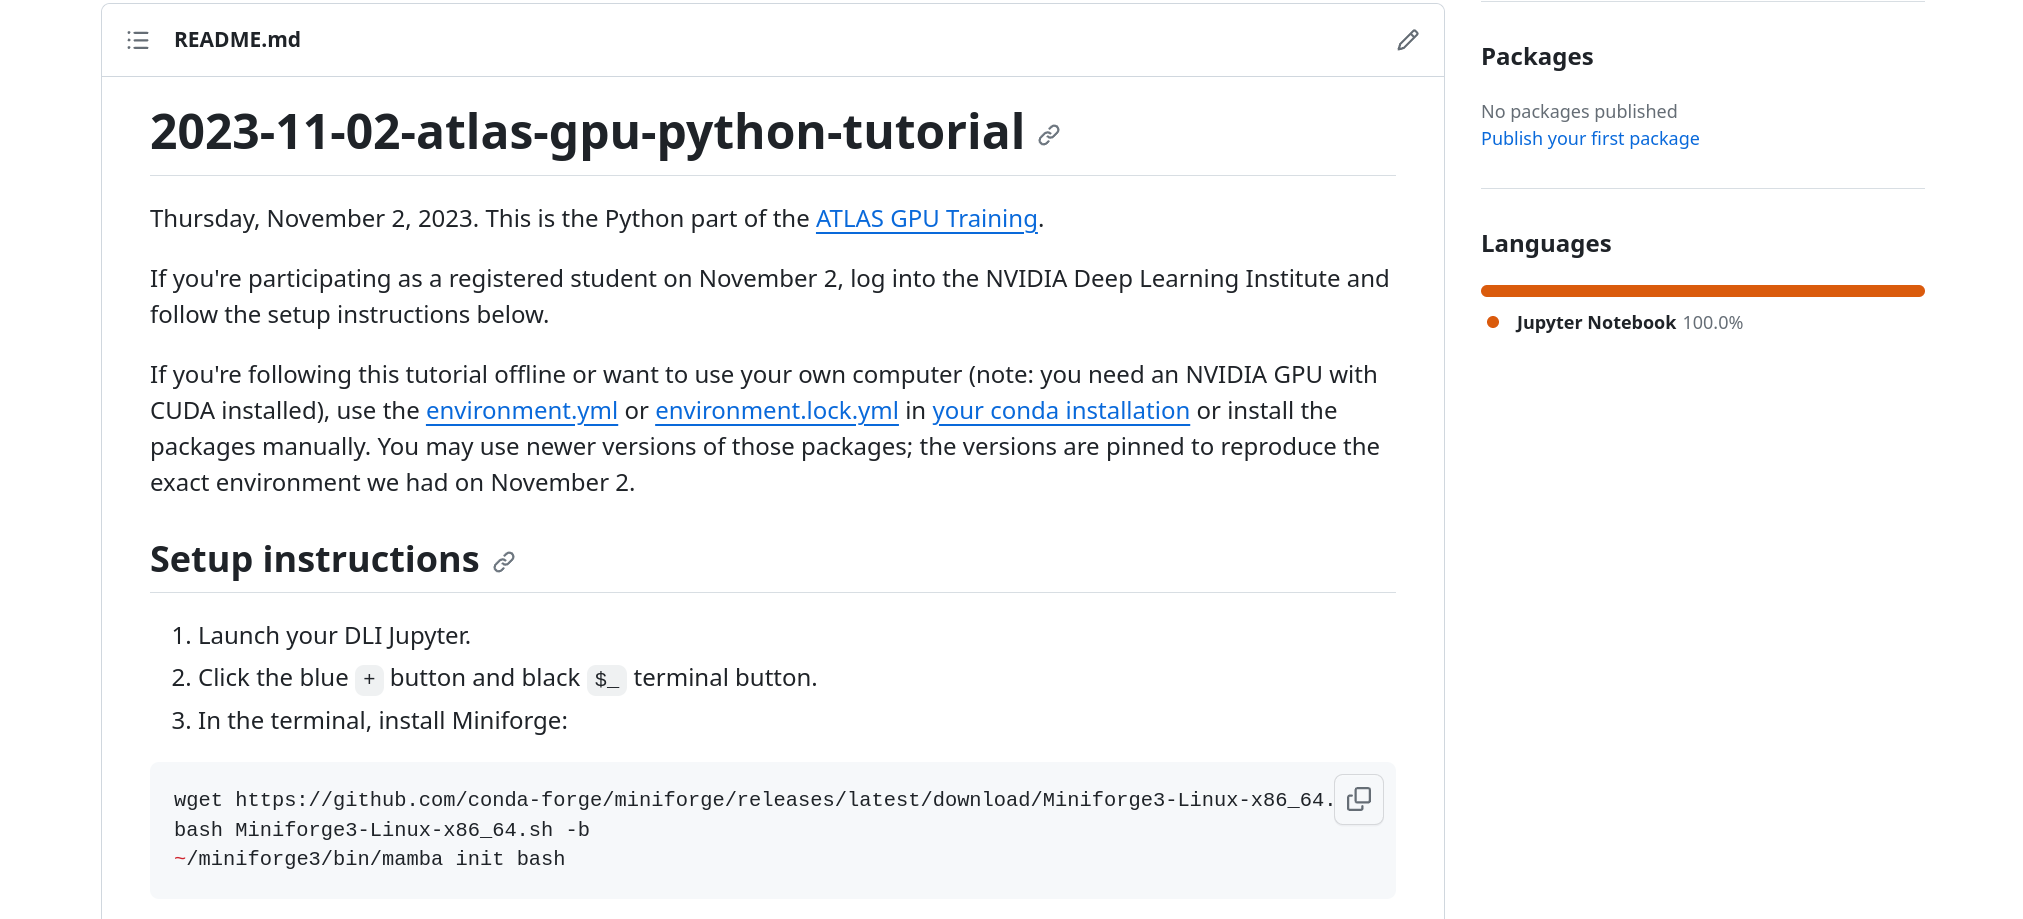

General plan: introductory lectures followed by two large projects.

You'll learn the most from the projects. Even if you don't solve the problems, trying them will make the solutions more meaningful.

<br>

* **0:00** (30 min) Introduce the Python tools; see [lecture-slides.ipynb](lecture-slides.ipynb) _(these slides)_
* **0:30** (20 min) Compute the Z mass in CUDA with Numba
* **0:50** (20 min) Introduce tree-reduction
* **1:10** (20 min) Students work on [Project 1: parallel histogram filling](projects/project-1-fill-histograms.ipynb)
* **1:30** (5 min) _break_
* **1:35** (20 min) Review [Project 1 solutions](solutions/project-1-fill-histograms.ipynb) _(don't peek until you've tried it!)_
* **1:55** (20 min) Introduce random seeding of parallel algorithms
* **2:15** (20 min) Students work on [Project 2: compute area by random sampling](projects/project-2-compute-area.ipynb)
* **2:35** (5 min) _break_
* **2:40** (20 min) Review [Project 2 solutions](solutions/project-2-compute-area.ipynb) _(don't peek until you've tried it!)_
* **3:00** _end_

Remember that you can ask questions in the Google Doc (on the day of the course) at

https://docs.google.com/document/d/1V0qfPrj710XG4d4eceqE0bD28V7tdttPT2tv8EOMOZQ

You can find this link at the bottom of the Indico overview page.

<br>

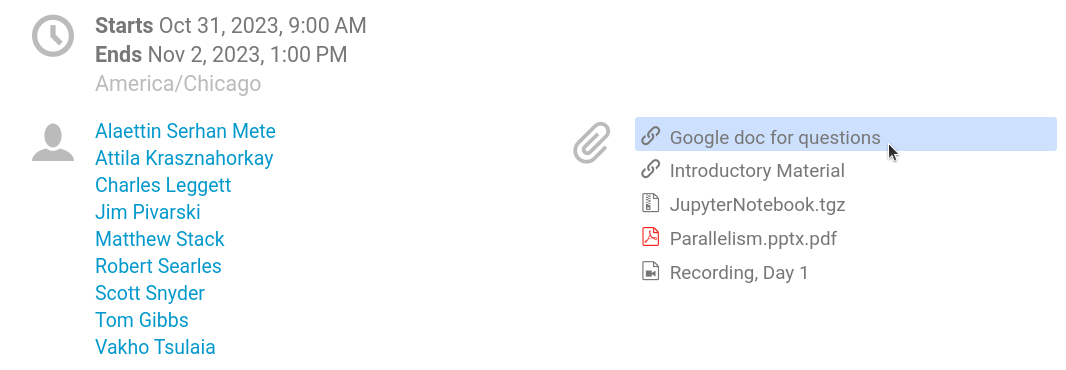

## Python tools for CUDA

<br>

You've learned about CUDA in a C++ context and all about the hardware.

However, Python is the world's most popular glue-language, connecting most of the tools you need in a common environment, including CUDA and C++.

In particular, machine learning (a very important case for GPUs!) is primarily Python-driven.

<center>
    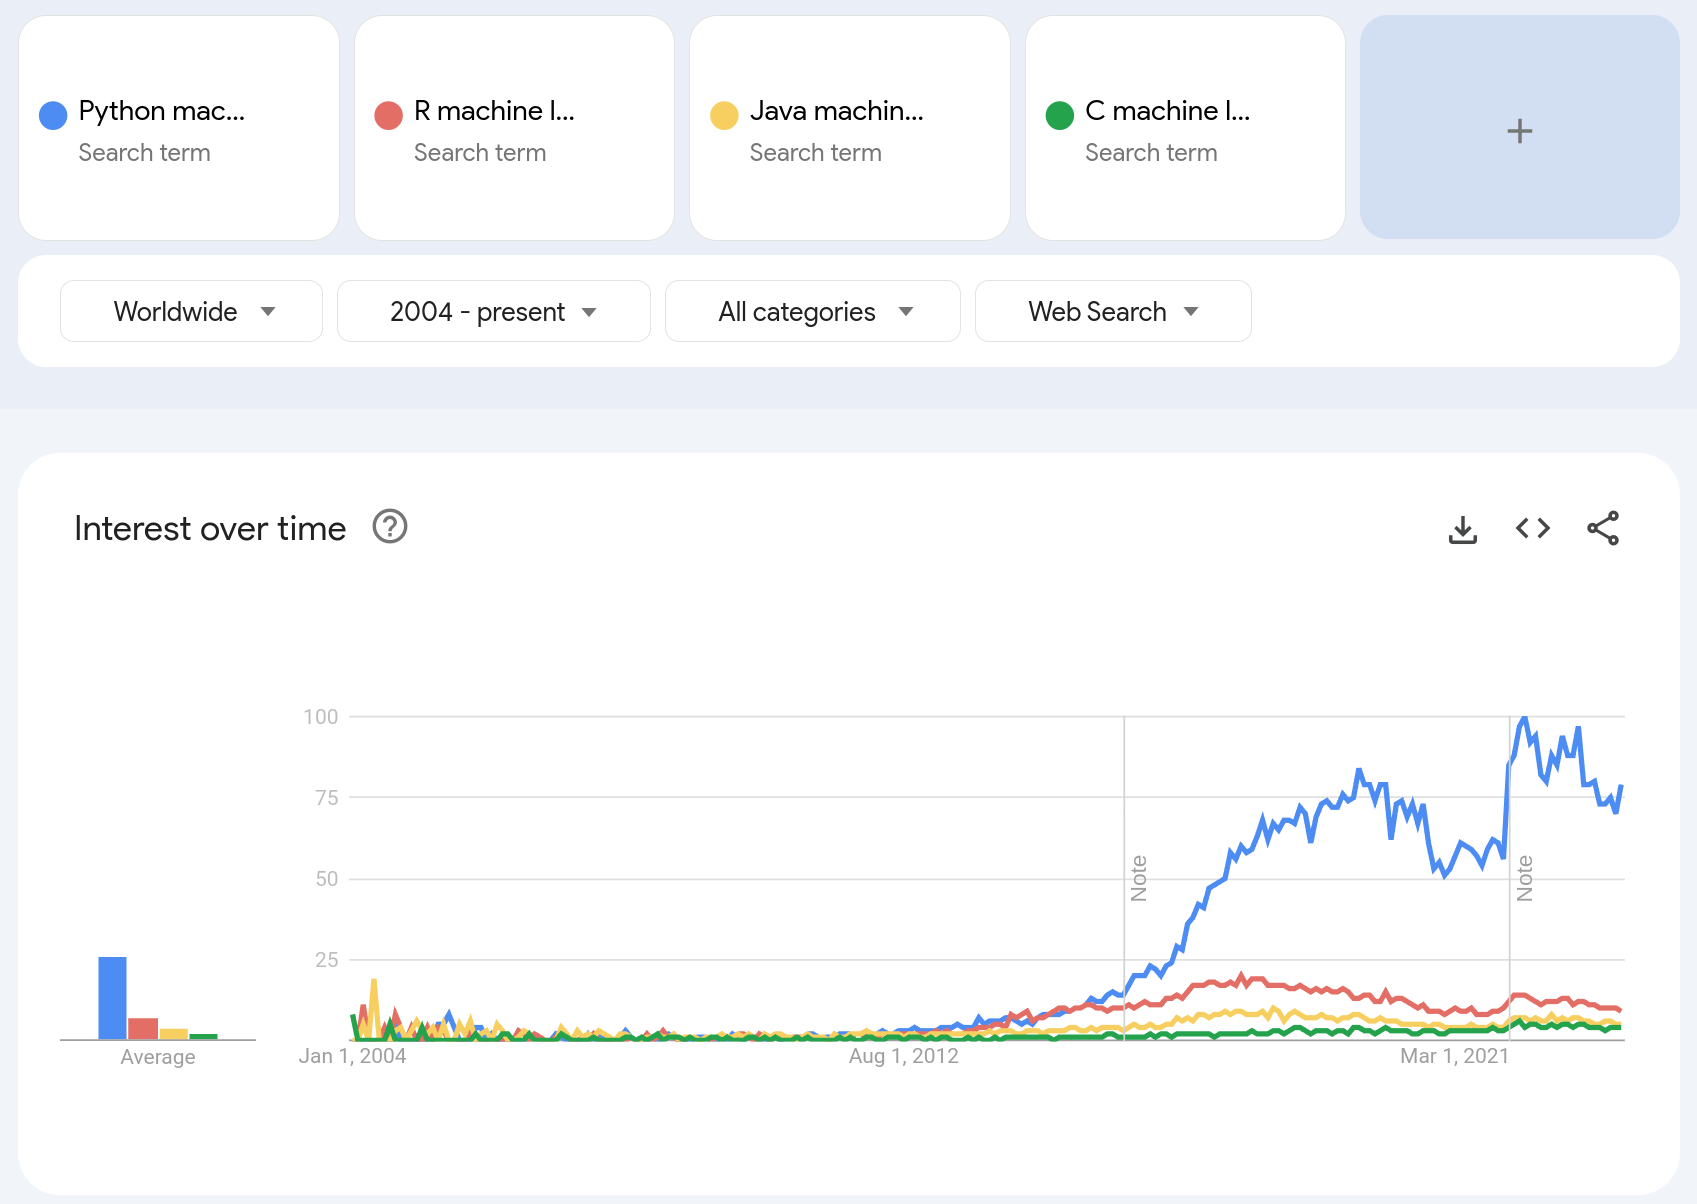
</center>

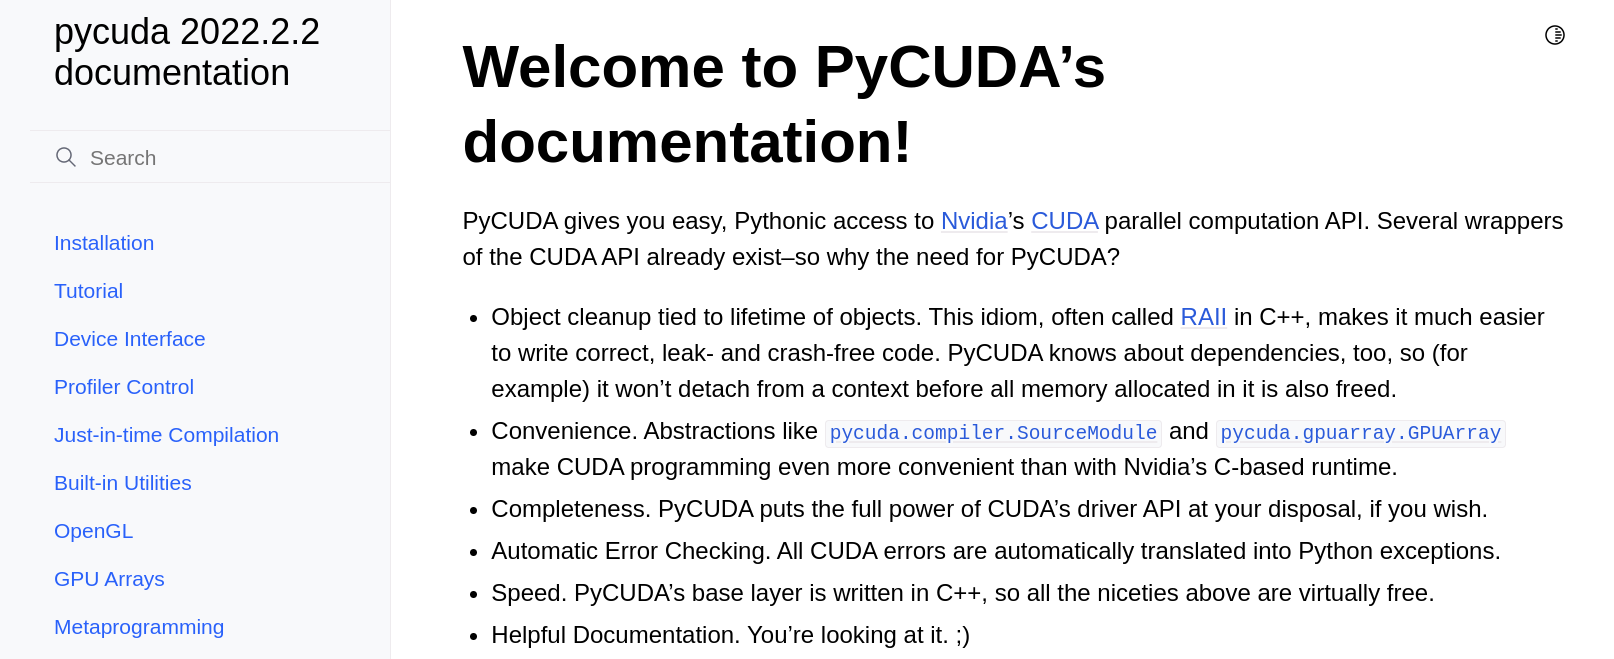

<br>

PyCUDA is one of the oldest (2008).

It has (or had?) 100% coverage of the CUDA API—anything you can do in CUDA C++ you can do in PyCUDA.

But also notice that the last release was well over a year ago...

In [1]:
import numpy as np
import pycuda.autoinit
import pycuda.compiler
import pycuda.driver as drv

module = pycuda.compiler.SourceModule(r'''
__global__ void increment(int* data) {
    data[threadIdx.x]++;
}
''')
pycuda_increment = module.get_function("increment")

<br>

In [2]:
data = np.arange(1024, dtype=np.int32)
data

array([   0,    1,    2, ..., 1021, 1022, 1023], dtype=int32)

<br>

In [3]:
pycuda_increment(drv.InOut(data), block=(1024, 1, 1))

<br>

In [4]:
data

array([   1,    2,    3, ..., 1022, 1023, 1024], dtype=int32)

PyCUDA is just a wrapper around C++ CUDA: kernels in C++ as Python strings.

<br><br><br>

Its value is that we can use C++ CUDA and all your favorite Python packages in the same script.

## Expressive use of compiled code in Python

<br>

For most math in Python, we use NumPy and libraries built on NumPy.

<br>

In [5]:
import numpy as np

array = np.arange(1, 13)
array

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

<br>

In [6]:
array**2

array([  1,   4,   9,  16,  25,  36,  49,  64,  81, 100, 121, 144])

This makes it possible to apply the same expressions to a set of equal-sized arrays as you would apply to scalar numbers.

<br>

In [7]:
def quadratic_formula(a, b, c):
    return (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)

quadratic_formula(5, 10, -0.1)

0.009950493836207741

<br>

In [8]:
a = np.random.uniform(5, 10, 1000000)
b = np.random.uniform(10, 20, 1000000)
c = np.random.uniform(-0.1, 0.1, 1000000)

quadratic_formula(a, b, c)

array([-0.00277181, -0.00674779, -0.00462504, ...,  0.00382427,
        0.00590665, -0.00218655])

Each operation on a whole array calls a precompiled function, which is an enormous speed-up relative to writing loops in Python.

<br>

In [9]:
%%timeit
for i in range(len(a)):
    quadratic_formula(a[i], b[i], c[i])

1.02 s ± 5.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<br>

In [10]:
%%timeit
quadratic_formula(a, b, c)

11 ms ± 223 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<br>

So, a factor of 100 in this case (not unusual).

<img src="img/Numpy_Python_Cheat_Sheet.svg" width="100%">

Natural question: why not do the same thing for arrays that

* live on the GPU (no copying back and forth)
* are operated upon by CUDA-compiled kernels?

<br>

In [11]:
import cupy as cp

array = cp.arange(1, 13)
array

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

<br>

In [12]:
array**2

array([  1,   4,   9,  16,  25,  36,  49,  64,  81, 100, 121, 144])

What this looks like to CUDA (in the profiler):

In [22]:
array = cp.random.uniform(5, 10, 100000000)
array.sort()
array

array([5.00000001, 5.00000003, 5.00000013, ..., 9.99999988, 9.99999998,
       9.99999999])

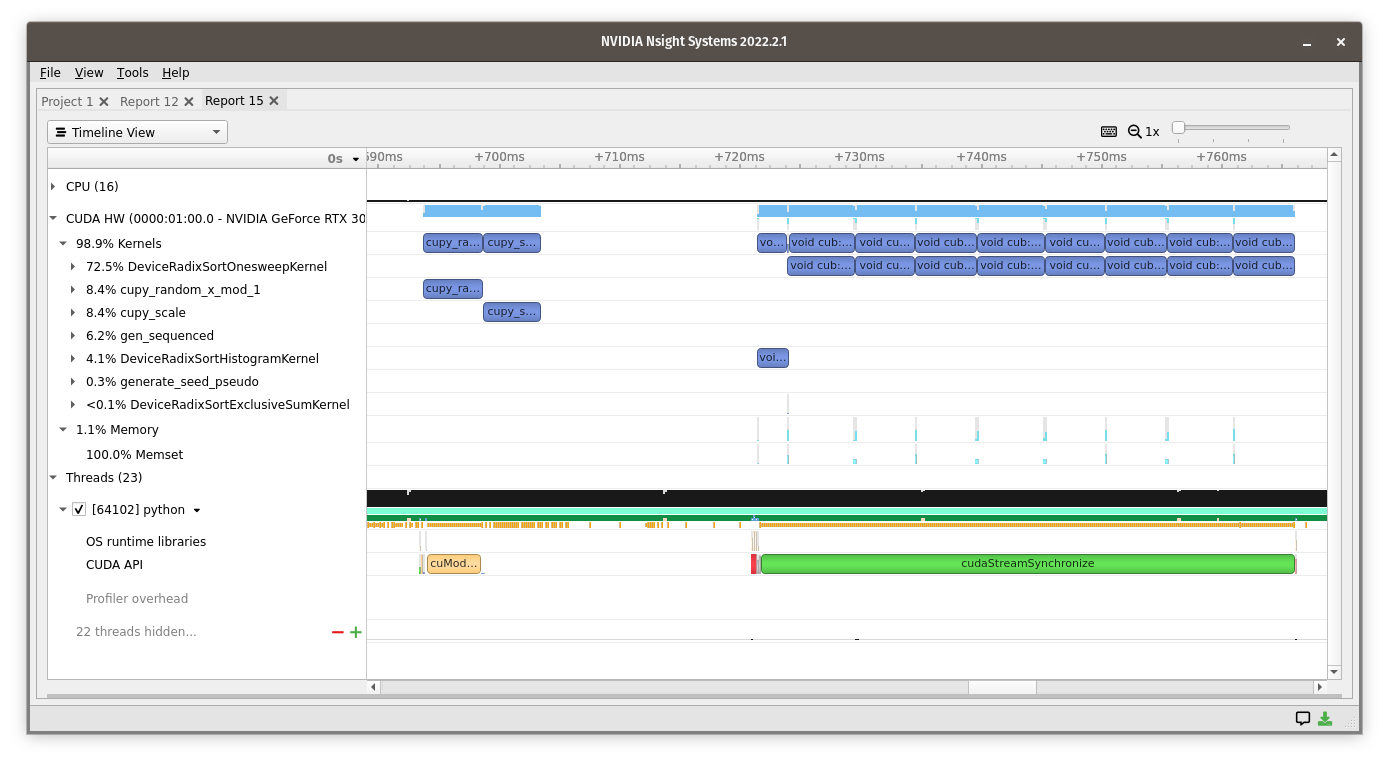

From a low-level CUDA perspective, CuPy does some surprising things:

* It allocates its own memory pools, so a new `cp.ndarray` does not mean a new `cudaMalloc`. (You can [control it](https://docs.cupy.dev/en/stable/user_guide/memory.html), but that's the default.)

* For performance reasons, it doesn't _perfectly_ reproduce the NumPy API. It's not _exactly_ a drop-in replacement, but it's close. ("Drop-in and fix-up.")

* Some things that would be errors in NumPy have definitions in CuPy:

<br>

In [14]:
array = cp.array([0.0, 1.1, 2.2, 3.3, 4.4, 5.5])
array[cp.array([2, 3, 5])]

array([2.2, 3.3, 5.5])

<br>

In [16]:
array[cp.array([2, 3, 5, 6, 7, 8])]

array([2.2, 3.3, 5.5, 0. , 1.1, 2.2])

While this array-at-a-time model is much faster than pure Python, computing

In [17]:
a = np.random.uniform(5, 10, 1000000)
b = np.random.uniform(10, 20, 1000000)
c = np.random.uniform(-0.1, 0.1, 1000000)

(-b + np.sqrt(b**2 - 4*a*c)) / (2*a)

array([-0.00075969,  0.00324626, -0.00402625, ..., -0.00713988,
       -0.00567508,  0.00719667])

<br>

is 9 passes over the data:

In [20]:
tmp1 = np.negative(b)            # -b
tmp2 = np.square(b)              # b**2
tmp3 = np.multiply(4, a)         # 4*a
tmp4 = np.multiply(tmp3, c)      # tmp3*c
del tmp3
tmp5 = np.subtract(tmp2, tmp4)   # tmp2 - tmp4
del tmp2, tmp4
tmp6 = np.sqrt(tmp5)             # sqrt(tmp5)
del tmp5
tmp7 = np.add(tmp1, tmp6)        # tmp1 + tmp6
del tmp1, tmp6
tmp8 = np.multiply(2, a)         # 2*a
np.divide(tmp7, tmp8)            # tmp7 / tmp8

array([-0.00075969,  0.00324626, -0.00402625, ..., -0.00713988,
       -0.00567508,  0.00719667])

Therefore, it's (at least) 9 CUDA kernels in CuPy:

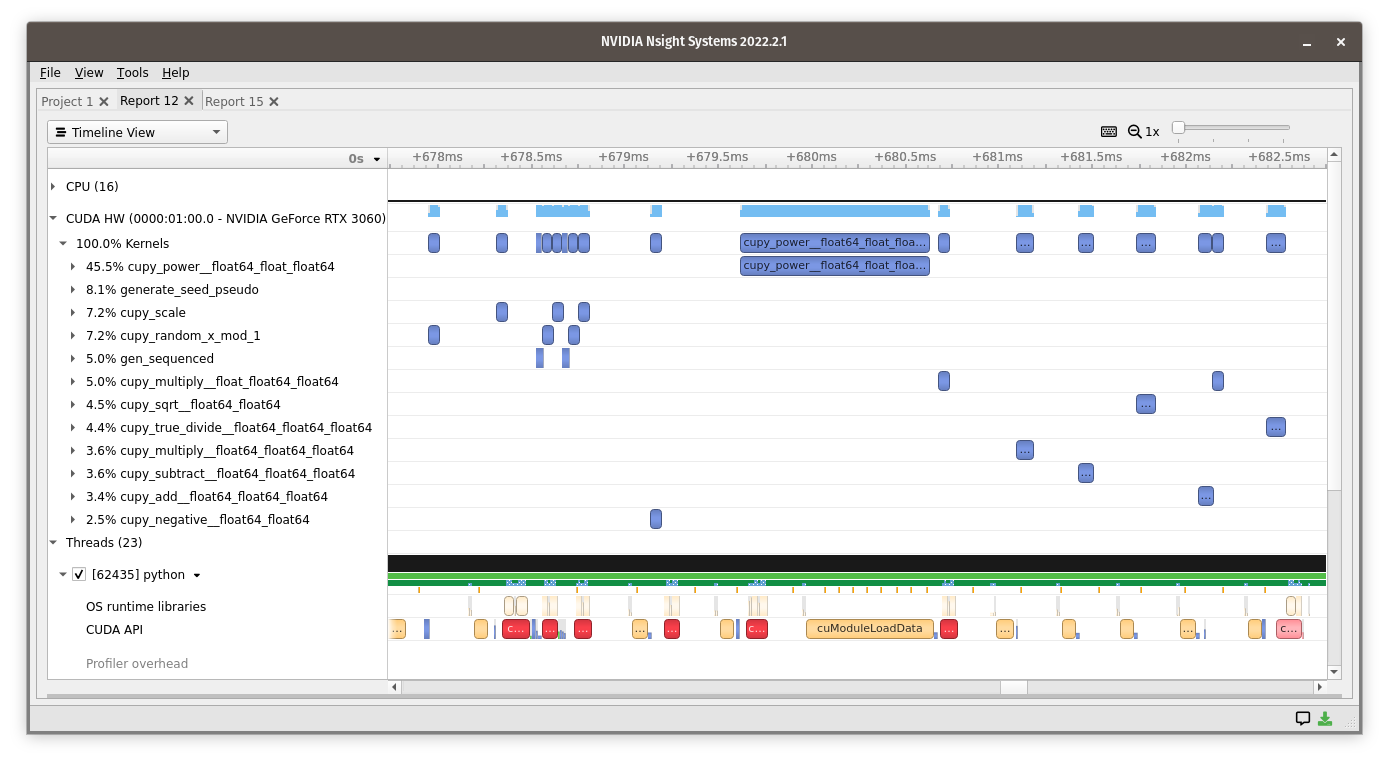

(and I just noticed that `b**2` is implemented as `pow(b, 2.0)`, rather than `b*b`!)

CuPy lets you fuse operations by [JIT-compiling them](https://docs.cupy.dev/en/stable/user_guide/kernel.html).

<br>

In [36]:
intpow = cp.ElementwiseKernel("float64 x, int64 n", "float64 out", '''
    out = 1.0;
    for (int i = 0;  i < n;  i++) {
        out *= x;
    }
''', "intpow")
intpow

<br>

In [37]:
a = cp.random.uniform(5, 10, 1000000)
b = cp.random.uniform(10, 20, 1000000)
c = cp.random.uniform(-0.1, 0.1, 1000000)

intpow(b, 2)

array([128.02765058, 162.82107428, 360.18800546, ..., 103.54285039,
       174.26376325, 200.9477173 ])

<br>

In [48]:
b**2

array([128.02765058, 162.82107428, 360.18800546, ..., 103.54285039,
       174.26376325, 200.9477173 ])

But we're back to compiling C++ in strings!

<br>

In [47]:
quadratic_formula_kernel = cp.RawKernel(r'''
extern "C" __global__ void
quadratic_formula(const double* a, const double* b, const double* c, double* out) {
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    out[i] = (-b[i] + sqrt(b[i]*b[i] - 4*a[i]*c[i])) / (2*a[i]);
}
''', "quadratic_formula")

out = cp.empty_like(a)

num_threads = 1024
num_blocks = int(np.ceil(len(out) / 1024))

quadratic_formula_kernel((num_blocks,), (num_threads,), (a, b, c, out))

out

array([ 0.0067227 , -0.00646806, -0.00157517, ...,  0.00852647,
       -0.00055844, -0.00056611])

Since CuPy can JIT-compile C++ CUDA, it supersedes PyCUDA and provides a NumPy-like array abstraction that is more-or-less standard.

<br>

"More-or-less standard" because most machine learning libraries provide their own:

<br>

In [61]:
import torch

a = torch.rand(1000000)*5 + 5
b = torch.rand(1000000)*10 + 10
c = torch.rand(1000000)*0.2 - 0.1

quadratic_formula(a, b, c)

tensor([-0.0007,  0.0056,  0.0040,  ..., -0.0069, -0.0058, -0.0031])

<br>

There is ongoing effort to bring these all into a single standard: https://data-apis.org/

## Compiling _Python code_ to run on GPUs

<br>

Although being able to compile C++ from Python strings gives us access to all of the C++ CUDA tools—intrinsics, libraries like CUB and Thrust, etc.—there are reasons to compile _Python code_ to run on GPUs.

* You can use the same Python types in and out of the GPU code.
* You can test parts of your algorithm—slowly—in pure Python during development.

Numba is a JIT-compiler of (a subset of) Python code with LLVM.

<br>

In [71]:
import numba as nb

@nb.njit
def quadratic_formula_numba(a, b, c):
    out = np.empty_like(a)
    for i in range(len(out)):
        out[i] = (-b[i] + np.sqrt(b[i]**2 - 4*a[i]*c[i])) / (2*a[i])
    return out

<br>

In [72]:
a = np.random.uniform(5, 10, 1000000)
b = np.random.uniform(10, 20, 1000000)
c = np.random.uniform(-0.1, 0.1, 1000000)

quadratic_formula_numba(a, b, c)

array([-0.00216368, -0.00128351,  0.00353405, ..., -0.0020767 ,
        0.00356025, -0.00341579])

This really is compiled, and you can see it in the performance:

<br>

Pure Python:

In [75]:
%%timeit
out = np.empty_like(a)
for i in range(len(out)):
    out[i] = (-b[i] + np.sqrt(b[i]**2 - 4*a[i]*c[i])) / (2*a[i])

1.14 s ± 5.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<br>

NumPy (9 precompiled passes over the arrays):

In [73]:
%%timeit
(-b + np.sqrt(b**2 - 4*a*c)) / (2*a)

5.98 ms ± 86.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<br>

Numba (1 precompiled pass over the array):

In [74]:
%%timeit
quadratic_formula_numba(a, b, c)

3.02 ms ± 4.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


And Numba can compile CUDA functions ([through LLVM → NNVM → PTX](https://medium.com/rapids-ai/the-life-of-a-numba-kernel-a-compilation-pipeline-taking-user-defined-functions-in-python-to-cuda-71cc39b77625)).

<br>

In [83]:
import numba.cuda
from numba.cuda.libdevice import sqrt

@nb.cuda.jit
def quadratic_formula_numba_cuda(a, b, c, out):
    i = nb.cuda.grid(1)   # 1-dimensional
    if i < len(out):
        out[i] = (-b[i] + sqrt(b[i]**2 - 4*a[i]*c[i])) / (2*a[i])

a = cp.random.uniform(5, 10, 1000000)
b = cp.random.uniform(10, 20, 1000000)
c = cp.random.uniform(-0.1, 0.1, 1000000)

out = cp.empty_like(a)

num_threads = 1024
num_blocks = int(np.ceil(len(out) / 1024))

quadratic_formula_numba_cuda[num_blocks, num_threads](a, b, c, out)

out

array([ 0.00560527, -0.00696864, -0.00051077, ..., -0.00222641,
        0.00342388,  0.00425774])

Here's `quadratic_formula_numba_cuda` in the profiler (running after CuPy).

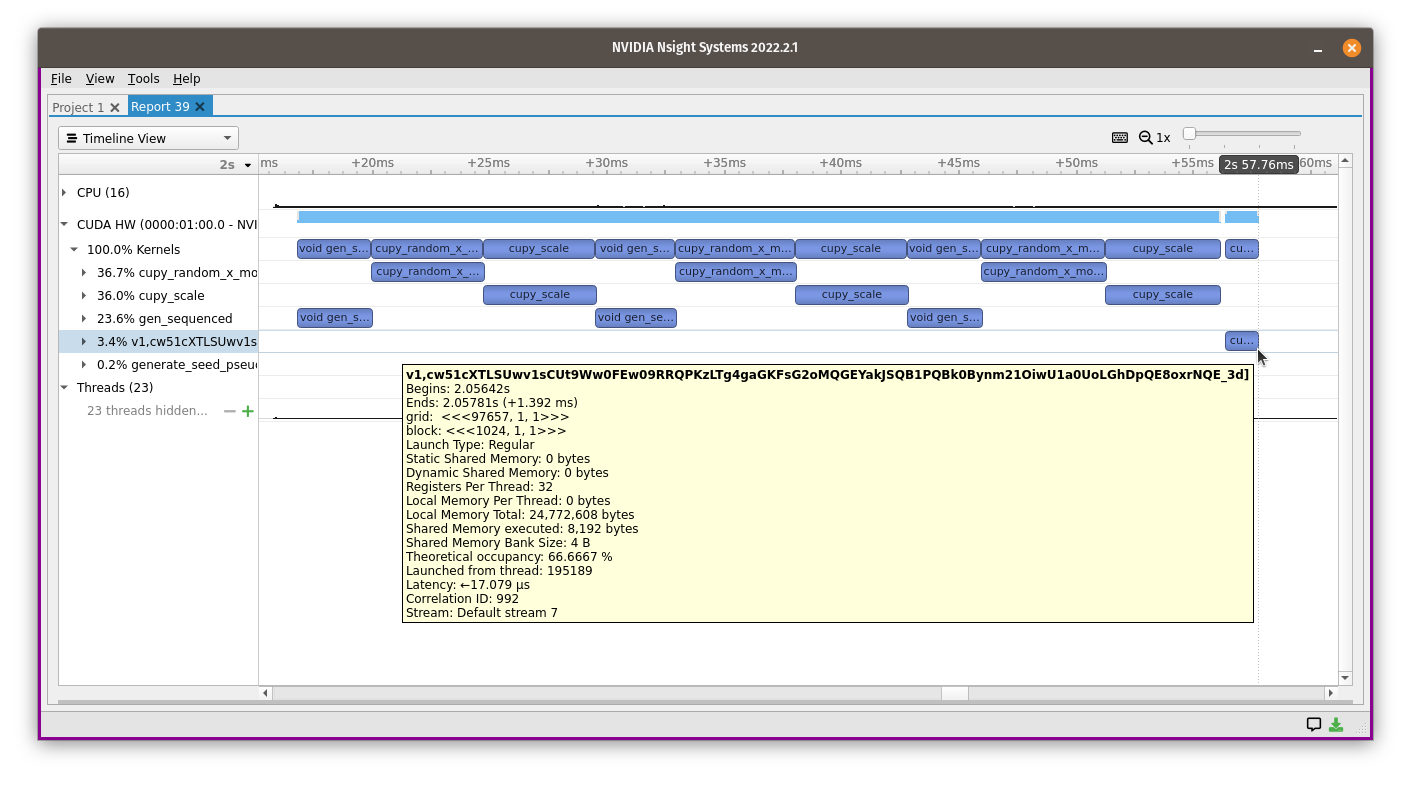

Summary of your options for using CUDA in Python:

* PyCUDA (obsolete)
* CuPy as an array library like NumPy
* CuPy to JIT-compile C++ in strings
* Machine learning libraries have their own ~~arrays~~ "tensors"
* Numba to JIT-compile (a subset of) Python as a kernel

* JAX JIT-compiles (and autodiffs) array-oriented code for CPU and GPU

See [Mandelbrot on all accelerators](https://drive.google.com/file/d/1J0l5e0NZm5kEm5BEUDG4neN5EN0VVCnt/view?usp=sharing) (Google Colab, linked in Indico) for an illustration of the trade-offs.

(It's an interesting example because it can't be fully vectorized.)

* C++ and Numba require an imperative programming style.
* NumPy, CuPy, and JAX require an array-oriented programming style.

<br>

<img src="img/plot-mandelbrot-on-all-accelerators.svg" width="100%">

* This example prompted a big discussion about JAX and Julia (linked at the bottom).

Summary of your options for using CUDA in Python:

* PyCUDA (obsolete)
* CuPy as an array library like NumPy
* CuPy to JIT-compile C++ in strings
* Machine learning libraries have their own ~~arrays~~ "tensors"
* Numba to JIT-compile (a subset of) Python as a kernel
* JAX JIT-compiles (and autodiffs) array-oriented code for CPU and GPU

* The RAPIDS project provides higher-level tools, like the CuDF DataFrame

In [106]:
import cudf

df = cudf.DataFrame({
    "jetid": cp.cumsum(cp.random.poisson(0.1, 1000000)),
    "px": cp.random.normal(0, 10, 1000000),
    "py": cp.random.normal(0, 10, 1000000),
    "pz": cp.random.normal(0, 10, 1000000),
    "E": cp.random.normal(20, 10, 1000000),
})
df

,jetid,px,py,pz,E
0,0,-14.907209,-14.371578,-1.152530,19.296149
1,0,-7.570123,-1.298481,2.518197,12.902066
2,0,-3.729506,-8.241945,-0.755276,33.863374
3,0,16.470975,-10.412037,-10.357030,4.274687
4,1,-1.611454,1.633237,-26.609865,8.088333
...,...,...,...,...,...
999995,99838,-4.518735,-1.801277,-5.189045,40.819258
999996,99838,-0.625156,-5.518252,-10.976113,23.258965
999997,99838,11.805794,6.536966,2.338486,24.148508
999998,99838,3.868878,20.073395,6.020781,19.633347


In [107]:
df.groupby("jetid").sum().sort_index()

,px,py,pz,E
jetid,,,,
0,-9.735862,-34.324041,-9.746639,70.336276
1,-29.918694,56.157604,45.026964,797.293042
4,4.292103,-23.212212,-14.718566,77.805246
5,-35.397934,-16.946128,-16.502466,155.943262
6,-29.034543,51.529529,-18.608548,300.149354
...,...,...,...,...
99834,-9.158945,20.507945,-14.076577,48.679192
99835,-29.350622,19.294325,4.419858,132.910788
99836,115.023555,-58.122018,-104.701931,791.798628


Summary of your options for using CUDA in Python:

* PyCUDA (obsolete)
* CuPy as an array library like NumPy
* CuPy to JIT-compile C++ in strings
* Machine learning libraries have their own ~~arrays~~ "tensors"
* Numba to JIT-compile (a subset of) Python as a kernel
* JAX JIT-compiles (and autodiffs) array-oriented code for CPU and GPU
* The RAPIDS project provides higher-level tools, like the CuDF DataFrame

* Awkward Arrays can be passed as arguments to Numba, even in CUDA mode

In [110]:
import awkward as ak

array = ak.Array([[1.1, 2.2, 3.3], [], [4.4, 5.5]])
array

<Array [[1.1, 2.2, 3.3], [], [4.4, 5.5]] type='3 * var * float64'>

<br>

In [111]:
array_cuda = ak.to_backend(array, "cuda")

<br>

In [112]:
type(array_cuda.layout.content.data)

cupy.ndarray

In [123]:
array_cuda

<Array [[1.1, 2.2, 3.3], [], [4.4, 5.5]] type='3 * var * float64'>

<br>

In [121]:
ak.numba.register_and_check()

@nb.cuda.jit(extensions=[ak.numba.cuda])
def sum_in_cuda(array, out):
    thread_idx = nb.cuda.grid(1)
    out[thread_idx] = 0
    for x in array[thread_idx]:
        out[thread_idx] += x

out = cp.empty(3, dtype=np.float64)

sum_in_cuda[1, 3](array_cuda, out)

<br>

In [122]:
out

array([6.6, 0. , 9.9])

## Computing Z mass on a GPU with Awkward Arrays